In [199]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [18]:
Crema = r"D:/University/Courses/Capstone/CREMA-D/AudioWAV/"

In [19]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,D:/University/Courses/Capstone/CREMA-D/AudioWA...
1,disgust,D:/University/Courses/Capstone/CREMA-D/AudioWA...
2,fear,D:/University/Courses/Capstone/CREMA-D/AudioWA...
3,happy,D:/University/Courses/Capstone/CREMA-D/AudioWA...
4,neutral,D:/University/Courses/Capstone/CREMA-D/AudioWA...


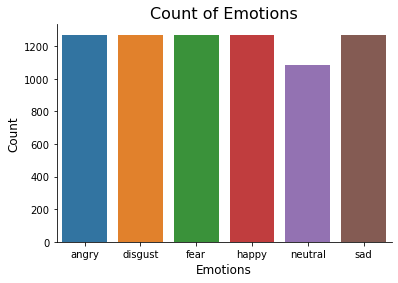

In [20]:
plt.title('Count of Emotions', size=16)
sns.countplot(Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [21]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

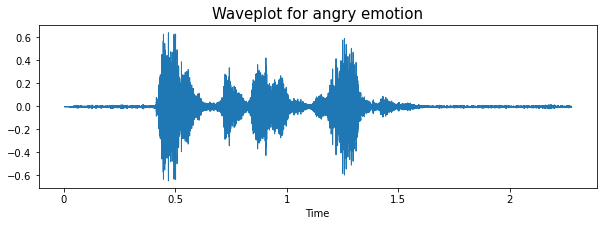

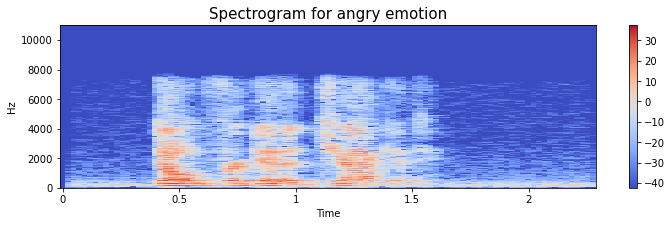

In [22]:
emotion='angry'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [23]:
labels = {'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}
Crema_df.replace({'Emotions':labels},inplace=True)

In [24]:
num_mfcc=13
n_fft=2048
hop_length=512
SAMPLE_RATE = 22050
data = {
        "labels": [],
        "mfcc": [],
        "zcr": [],
        "chroma_stft": [],
        "rms": [],
        "melspectrogram": []
    }
for i in range(7442):
    data['labels'].append(Crema_df.iloc[i,0])
    signal, sample_rate = librosa.load(Crema_df.iloc[i,1], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T
    data["mfcc"].append(np.asarray(mfcc))
    zcr = librosa.feature.zero_crossing_rate(signal, sample_rate)
    zcr = zcr.T
    data["zcr"].append(np.asarray(zcr))
    chroma_stft = librosa.feature.chroma_stft(signal, sample_rate)
    chroma_stft = chroma_stft.T
    data["chroma_stft"].append(np.asarray(chroma_stft))
    rms = librosa.feature.rms(signal, sample_rate)
    rms = rms.T
    data["rms"].append(np.asarray(rms))
    melspectrogram = librosa.feature.melspectrogram(signal, sample_rate)
    melspectrogram = melspectrogram.T
    data["melspectrogram"].append(np.asarray(melspectrogram))
    if i%500==0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [25]:
import pickle

with open('data_dict_all.pkl', 'wb') as f:
    pickle.dump(data, f)

In [170]:
with open('data_dict_all.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

In [171]:
loaded_data.keys()

dict_keys(['labels', 'mfcc', 'zcr', 'chroma_stft', 'rms', 'melspectrogram'])

In [172]:
X = np.asarray(loaded_data["mfcc"])
y = np.asarray(data["labels"])

In [173]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(7442, 216, 13)

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [175]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)

(5357, 216, 13) (5357,) (1340, 216, 13) (1340,) (745, 216, 13) (745,)


In [194]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(6, activation='softmax'))

    return model

In [195]:
# create network
input_shape = (None,13)
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, None, 128)         72704     
                                                                 
 lstm_25 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_26 (LSTM)              (None, None, 64)          49408     
                                                                 
 lstm_27 (LSTM)              (None, 64)                33024     
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 6)               

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 10)
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=150, callbacks=[es])

Epoch 1/150
 15/168 [=>............................] - ETA: 4:06 - loss: 1.7721 - accuracy: 0.2042

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)